In [35]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [24]:
SHIP_AGE = 20

In [25]:
def select_ship(spec, cost, year):
    opex_sum    = spec.num_sf * cost.Seafarer[year] \
                + spec.num_so * cost.ShoreOpe[year] \
                + spec.sec_cost * cost.CS[year] \
                + spec.com_cost * cost.Comm[year]
    capex_sum   = spec.sa_cost * cost.Situ[year] \
                + spec.pl_cost * cost.Plan[year] \
                + spec.ex_cost * cost.Exec[year] \
                + spec.ro_cost * cost.RemOpe[year] \
                + spec.rm_cost * cost.RemMon[year]
    ac_loss     = spec.acc_ratio * cost.ExpLoss[year]
    annual_cost = opex_sum + capex_sum/SHIP_AGE + ac_loss
    sf_sum      = spec.num_sf + spec.num_so
    select      = annual_cost.idxmin()
    
    return select, annual_cost, opex_sum, capex_sum, ac_loss, sf_sum

In [26]:
cost = pd.read_csv("csv/cost.csv")
spec = pd.read_csv("csv/spec.csv")
demand = pd.read_csv("csv/demand.csv")

In [27]:
spec['sa_cost'] = 0
spec['sa_cost'][spec['SituationAwareness'].isin(['FullAuto'])] = 1
spec['sa_cost'][spec['SituationAwareness'].isin(['SemiAuto'])] = 0.5
spec['pl_cost'] = 0
spec['pl_cost'][spec['Planning'].isin(['FullAuto'])] = 1
spec['pl_cost'][spec['Planning'].isin(['SemiAuto'])] = 0.5
spec['ex_cost'] = 0
spec['ex_cost'][spec['Control'].isin(['FullAuto'])] = 1
spec['ex_cost'][spec['Control'].isin(['SemiAuto'])] = 0.5
spec['ro_cost'] = 0
spec['ro_cost'][spec['Remote'].isin(['Control'])] = 1
spec['rm_cost'] = 0
spec['rm_cost'][spec['Remote'].isin(['Monitor'])] = 1

<ipython-input-27-0b2803c9449f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spec['sa_cost'][spec['SituationAwareness'].isin(['FullAuto'])] = 1
<ipython-input-27-0b2803c9449f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spec['sa_cost'][spec['SituationAwareness'].isin(['SemiAuto'])] = 0.5
<ipython-input-27-0b2803c9449f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spec['pl_cost'][spec['Planning'].isin(['FullAuto'])] = 1
<ip

year= 2050


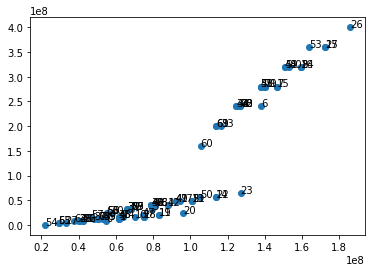

In [28]:
select = [0] * 50
labels = []

for i in range(50):
    select[i], annual_cost, opex_sum, capex_sum, ac_loss, sf_sum = select_ship(spec, cost, i)

    if cost.Year[i] == 2050:
        print('year=', cost.Year[i])
        plt.scatter(x=annual_cost, y=ac_loss*sf_sum)
        for j, label in enumerate(spec.index.values):
            plt.text(annual_cost[j], ac_loss[j]* sf_sum[j], label)

In [30]:
for i in list(set(spec.ship_type[select])):
    demand[i] = 0

# list(set(spec.ship_type[select]))

demand[spec.ship_type[80]] = 0     

In [31]:
demand[spec.ship_type[80]][0] = demand.NumofShip[0] # Initial num of ship
for i in range(50):
    demand[spec.ship_type[select[i]]][i] = demand.Newbuilding[i]
    if i >= 1:
        demand[spec.ship_type[select[i]]][i] += demand[spec.ship_type[select[i]]][i-1] + demand.Newbuilding[i]
    if i-SHIP_AGE > 0:
        demand[spec.ship_type[select[i-SHIP_AGE-1]]][i] -= demand.Newbuilding[i-SHIP_AGE-1]
    if i >= 1 and i <= SHIP_AGE:
        demand[spec.ship_type[80]][i] += demand[spec.ship_type[80]][i-1] - demand['Scrap'][i]   

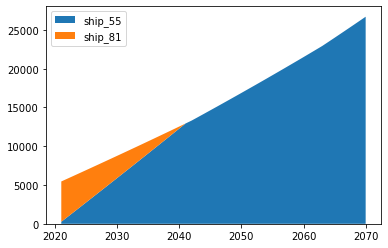

In [34]:
labels = list(set(spec.ship_type[select]))
labels.append(spec.ship_type[80])
fig, ax = plt.subplots()
ax.stackplot(demand.Year, demand[spec.ship_type[select[0]]], demand[spec.ship_type[80]], labels=labels)
ax.legend(loc="upper left")

plt.show()